# **Tucson Crime Analysis: Income and Street Lighting Impact**

## **Hypotheses**
* **Thefts/Violent Crime vs Area**: Do thefts and violent crimes occur more often in richer or poorer neighborhoods?
* **Crime Rate vs Streelight Presence**: Does the existance/prescence of city streetlights influence crime rates

---

## **Data Sources**
The data used for this analysis is sourced from the following links:

* [Tucson Police Reported Crimes](https://drive.google.com/file/d/1CpVZ9zpfggyClgxJpz4A6kMvm9bSospO/view?usp=sharing) — [Link to CSV](https://drive.google.com/file/d/161iT39q-IjdAwfS4nYs8reUbW9VMtub1/view?usp=drive_link)
* [Tucson Police Arrests](https://gisdata.tucsonaz.gov/datasets/7c7c881c1fff44ec8a8c2ab612700271_67/explore?location=32.456286%2C-111.225550%2C8.22) — [Link to CSV](https://drive.google.com/file/d/1bJnk0YaQ8xNQAeIJLMWA87VILOG2tEsl/view?usp=drive_link)
* [City of Tucson Streetlight Locations](https://gisdata.tucsonaz.gov/datasets/09ed59b6aae2483aa1bd32837d4aa7e5_19/explore?location=32.193107%2C-110.900400%2C11.16) — [Link to CSV](https://drive.google.com/file/d/1PWVC5zM-AffD-WDhN-9h5rAeCRRMRtac/view?usp=drive_link)
* [Neighborhood Income](https://gisdata.tucsonaz.gov/datasets/59f033d07eae41b0bdc21db87375d721_0/explore?location=32.197986%2C-110.889177%2C10.92) — [Link to CSV](https://drive.google.com/file/d/1_Ys0zVHxuI-XVIq5UpbJJW0Y7Lf0_rPA/view?usp=drive_link)
* [Geocoded Addresses from Arrests via Census Bureau API](https://geocoding.geo.census.gov/geocoder/)
* [Neighborhood geocoded data from the OpenCage API](https://opencagedata.com/api) (1,000 free requests / day)

---

## **Setup and Libraries**

The following libraries are used to analyze and model the data:
* `pandas` and `numpy`: Data manipulation and analysis
* `matplotlib` and `seaborn`: Data visualization
* `statsmodels` and `scikit-learn`: Statistical modeling and machine learning
* `geopy`: Geocoding for location-based analysis

Note: The following code assumes the datasets have been downloaded and stored in Google Drive for access during analysis.


##Importing libraries and loading datasets

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# this assumes you have downloaded the training dataset to the My Drive/datasets folder.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading and generalizing datasets**

Before we begin with our analysis, we'll first begin by loading in the appropiate files. Following, we'll merge and normalize the following datasets:
1. **Reported Crime Dataset**
2. **Arrests Dataset**: Provides insight on arrests, such as the date and time of such an occurrence

The merged dataset will be normalized to prepare for further analysis.

In [ ]:
# Load datasets /content/...
crimes = pd.read_csv('/content/Tucson_Police_Reported_Crimes.csv')
arrests = pd.read_csv('/content/Tucson_Police_Arrests_-_2021_-_Open_Data.csv')
streetlights = pd.read_csv('/content/Streetlights_-_City_of_Tucson_-_Open_Data.csv')
income = pd.read_csv('/content/Neighborhood_Income.csv')

# Display basic info
print("Crimes Shape:", crimes.shape)
print("Arrests Shape:", arrests.shape)
print("Streetlights Shape:", streetlights.shape)
print("Income Shape:", income.shape)\


# Now,

Crimes Shape: (205478, 14)
Arrests Shape: (45421, 39)
Streetlights Shape: (22781, 21)
Income Shape: (159, 168)


In [ ]:
# Crimes: Parse datetime and filter
crimes['DateOccurred'] = pd.to_datetime(crimes['DateOccurred'])
crimes = crimes[['DateOccurred', 'TimeOccur', 'Division', 'Ward', 'UCRDescription', 'OffenseDescription']].dropna(subset=['Ward'])

# Arrests: Create GeoDataFrame and categorize charges
arrests = arrests.dropna(subset=['X', 'Y', 'WARD'])
arrests_gdf = gpd.GeoDataFrame(arrests, geometry=[Point(xy) for xy in zip(arrests['X'], arrests['Y'])], crs="EPSG:2868")
arrests['ChargeType'] = arrests['fel_misd'].map({'F': 'Felony', 'M': 'Misdemeanor'})

# Streetlights: Filter active and create GeoDataFrame
streetlights = streetlights[streetlights['Status'] == 'Active'][['X', 'Y', 'Bulb_Type', 'Wattage']].dropna()
streetlights_gdf = gpd.GeoDataFrame(streetlights, geometry=[Point(xy) for xy in zip(streetlights['X'], streetlights['Y'])], crs="EPSG:2868")
streetlights['Bulb_Type'] = streetlights['Bulb_Type'].str.upper()

# Income: Select relevant columns
income = income[['WARD', 'NAME', 'MEDHINC_CY']].dropna()

In [ ]:
# Aggregate crimes by ward
crime_counts = crimes.groupby('Ward').size().reset_index(name='CrimeCount')

# Aggregate arrests by ward and charge type
arrest_counts = arrests.groupby(['WARD', 'ChargeType']).size().unstack(fill_value=0).reset_index()
arrest_counts.columns = ['WARD', 'FelonyCount', 'MisdemeanorCount']

# Spatial join to count streetlights per ward (assuming ward boundaries available or approximated)
# Note: For simplicity, we'll assume wards align with arrests' ward labels
streetlight_counts = arrests_gdf[['WARD']].drop_duplicates()
streetlight_counts['StreetlightCount'] = streetlight_counts['WARD'].apply(
    lambda w: len(streetlights_gdf[streetlights_gdf.geometry.within(arrests_gdf[arrests_gdf['WARD'] == w].geometry.unary_union.buffer(1000))])
)

# Merge datasets
data = income.merge(crime_counts, left_on='WARD', right_on='Ward', how='left')
data = data.merge(arrest_counts, on='WARD', how='left')
data = data.merge(streetlight_counts[['WARD', 'StreetlightCount']], on='WARD', how='left')
data = data.fillna(0)  # Fill missing counts with 0

<ipython-input-4-1cc0e924a5e3>:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda w: len(streetlights_gdf[streetlights_gdf.geometry.within(arrests_gdf[arrests_gdf['WARD'] == w].geometry.unary_union.buffer(1000))])
<ipython-input-4-1cc0e924a5e3>:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda w: len(streetlights_gdf[streetlights_gdf.geometry.within(arrests_gdf[arrests_gdf['WARD'] == w].geometry.unary_union.buffer(1000))])
<ipython-input-4-1cc0e924a5e3>:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda w: len(streetlights_gdf[streetlights_gdf.geometry.within(arrests_gdf[arrests_gdf['WARD'] == w].geometry.unary_union.buffer(1000))])
<ipython-input-4-1cc0e924a5e3>:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda w: len(streetlights_gdf[

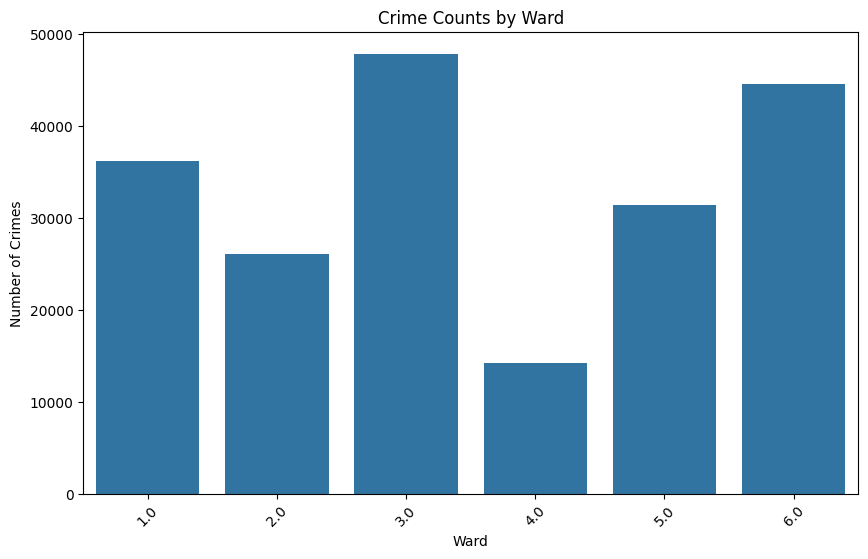

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Ward', y='CrimeCount', data=data)
plt.title('Crime Counts by Ward')
plt.xlabel('Ward')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.savefig('crime_by_ward.png')
plt.show()

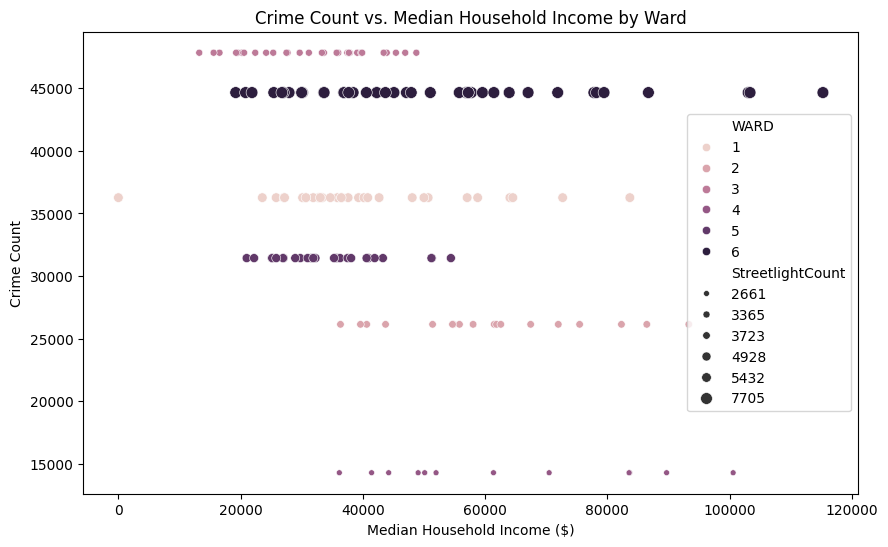

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MEDHINC_CY', y='CrimeCount', size='StreetlightCount', hue='WARD', data=data)
plt.title('Crime Count vs. Median Household Income by Ward')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Crime Count')
plt.savefig('income_vs_crime.png')
plt.show()

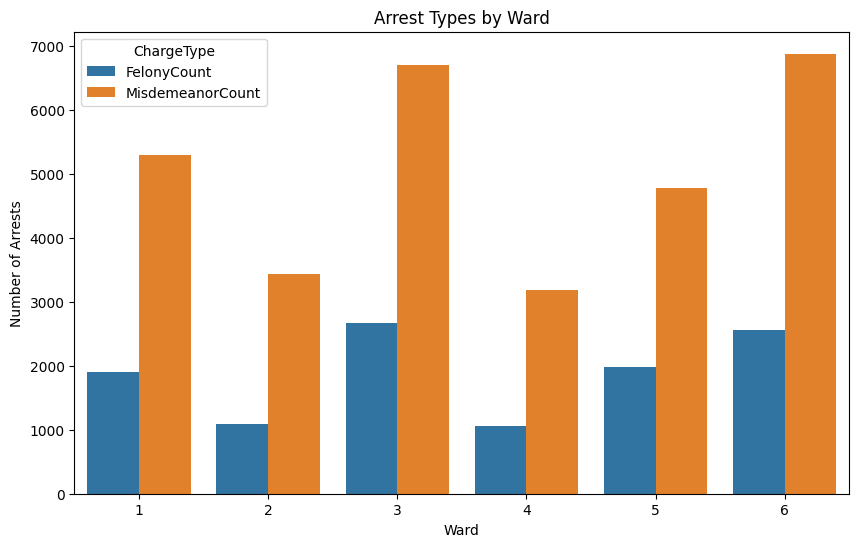

In [ ]:
arrest_melt = data.melt(id_vars=['WARD'], value_vars=['FelonyCount', 'MisdemeanorCount'], var_name='ChargeType', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='WARD', y='Count', hue='ChargeType', data=arrest_melt)
plt.title('Arrest Types by Ward')
plt.xlabel('Ward')
plt.ylabel('Number of Arrests')
plt.savefig('arrest_types_by_ward.png')
plt.show()

Linear Regression MSE: 74554377.03


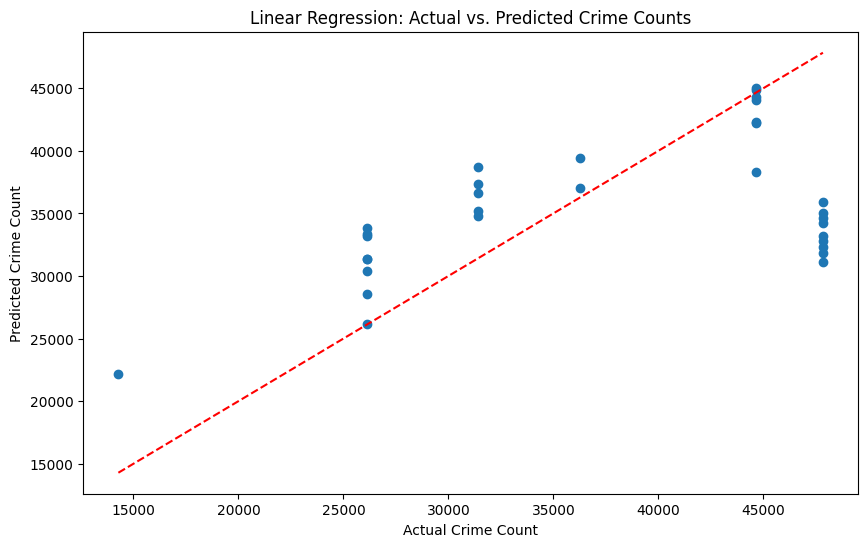

In [ ]:
# Prepare data
X = data[['MEDHINC_CY', 'StreetlightCount']]
y = data['CrimeCount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Actual vs. Predicted Crime Counts')
plt.xlabel('Actual Crime Count')
plt.ylabel('Predicted Crime Count')
plt.savefig('lr_predictions.png')
plt.show()

NaN in arrests_features before fill:
MEDHINC_CY          0
StreetlightCount    0
dtype: int64
NaN in arrests_features after fill:
MEDHINC_CY          0
StreetlightCount    0
dtype: int64
NaN in X:
MEDHINC_CY          0
StreetlightCount    0
dtype: int64
Random Forest Accuracy: 0.73
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Felony       0.00      0.00      0.00     66025
 Misdemeanor       0.73      1.00      0.84    175890

    accuracy                           0.73    241915
   macro avg       0.36      0.50      0.42    241915
weighted avg       0.53      0.73      0.61    241915



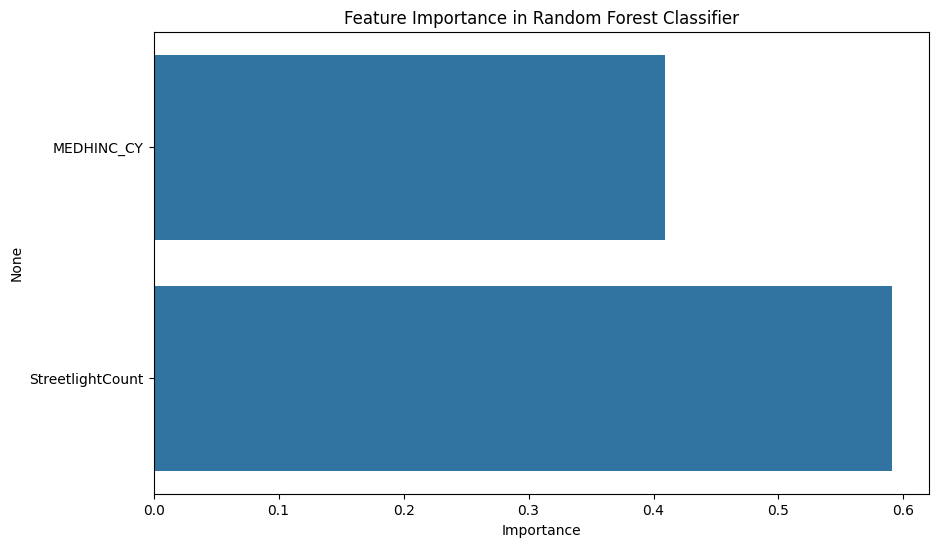

In [ ]:
# Prepare data (use arrests dataset with ward-level features)
arrests_features = arrests.merge(data[['WARD', 'MEDHINC_CY', 'StreetlightCount']], on='WARD', how='left')

# Check for NaN in merged data
print("NaN in arrests_features before fill:")
print(arrests_features[['MEDHINC_CY', 'StreetlightCount']].isna().sum())

# Ensure numeric types and fill NaN
arrests_features['MEDHINC_CY'] = pd.to_numeric(arrests_features['MEDHINC_CY'], errors='coerce').fillna(0)
arrests_features['StreetlightCount'] = pd.to_numeric(arrests_features['StreetlightCount'], errors='coerce').fillna(0)

# Verify no NaN remain
print("NaN in arrests_features after fill:")
print(arrests_features[['MEDHINC_CY', 'StreetlightCount']].isna().sum())

# Prepare features and target
X = arrests_features[['MEDHINC_CY', 'StreetlightCount']]
y = arrests_features['ChargeType'].dropna()  # Drop any NaN in target
X = X.loc[y.index]  # Align X with y after dropping NaN

# Verify no NaN in X
print("NaN in X:")
print(X.isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title('Feature Importance in Random Forest Classifier')
plt.xlabel('Importance')
plt.savefig('rf_feature_importance.png')
plt.show()

In [ ]:
# Select variables for correlation
corr_data = data[['CrimeCount', 'FelonyCount', 'MisdemeanorCount', 'MEDHINC_CY', 'StreetlightCount']]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Crime, Arrests, Income, and Streetlights')
plt.savefig('correlation_heatmap.png')
plt.show()

NameError: name 'data' is not defined